# Import Libraries

In [61]:
import requests
from time import sleep
import json
import pandas as pd
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns=999
pd.options.display.max_rows=999 

# Load JSON of cards

In [62]:
scryfall = pd.read_json('Data/scryfall-default-cards.json')

In [63]:
scryfall.columns

Index(['all_parts', 'arena_id', 'artist', 'artist_ids', 'booster',
       'border_color', 'card_back_id', 'card_faces', 'cmc', 'collector_number',
       'color_identity', 'color_indicator', 'colors', 'digital', 'edhrec_rank',
       'flavor_text', 'foil', 'frame', 'frame_effects', 'full_art', 'games',
       'hand_modifier', 'highres_image', 'id', 'illustration_id', 'image_uris',
       'lang', 'layout', 'legalities', 'life_modifier', 'loyalty', 'mana_cost',
       'mtgo_foil_id', 'mtgo_id', 'multiverse_ids', 'name', 'nonfoil',
       'object', 'oracle_id', 'oracle_text', 'oversized', 'power', 'preview',
       'printed_name', 'printed_text', 'printed_type_line',
       'prints_search_uri', 'promo', 'promo_types', 'rarity', 'related_uris',
       'released_at', 'reprint', 'reserved', 'rulings_uri', 'scryfall_set_uri',
       'scryfall_uri', 'set', 'set_name', 'set_search_uri', 'set_type',
       'set_uri', 'story_spotlight', 'tcgplayer_id', 'textless', 'toughness',
       'type_line',

In [64]:
scryfall.drop(columns=['arena_id','artist_ids','booster','border_color','card_back_id','card_faces',
                       'collector_number','digital','flavor_text','foil','frame','frame_effects','full_art',
                       'hand_modifier','id','illustration_id','life_modifier','mtgo_foil_id','mtgo_id',
                       'multiverse_ids','nonfoil','object','oracle_id','printed_name','prints_search_uri',
                       'promo_types','rarity','related_uris','rulings_uri','scryfall_set_uri','set_type',
                       'set_uri','story_spotlight','uri','variation','variation_of','watermark'],inplace=True)

In [65]:
scryfall.columns

Index(['all_parts', 'artist', 'cmc', 'color_identity', 'color_indicator',
       'colors', 'edhrec_rank', 'games', 'highres_image', 'image_uris', 'lang',
       'layout', 'legalities', 'loyalty', 'mana_cost', 'name', 'oracle_text',
       'oversized', 'power', 'preview', 'printed_text', 'printed_type_line',
       'promo', 'released_at', 'reprint', 'reserved', 'scryfall_uri', 'set',
       'set_name', 'set_search_uri', 'tcgplayer_id', 'textless', 'toughness',
       'type_line'],
      dtype='object')

**Filter out cards that are not commander legal**

In [66]:
scryfall.legalities = [card['commander'] for card in scryfall.legalities]

In [67]:
scryfall = scryfall[scryfall.legalities=='legal']

**Not including reserved cards because they are expensive**

In [68]:
scryfall = scryfall[scryfall.reserved==False]

**Commander is meant to promote socializing, so only including cards that can be physically played**

In [69]:
scryfall.games = ['paper' in card for card in scryfall.games]

In [70]:
scryfall = scryfall[scryfall.games]

**English versions of cards only**

In [71]:
scryfall = scryfall[scryfall.lang=='en']

In [72]:
scryfall.shape

(37816, 34)

**Leave out promotional cards**

In [73]:
scryfall = scryfall[scryfall.promo==False]

In [74]:
scryfall.shape

(35149, 34)

**Each card reprint has its own entry in the dataset. Therefore drop all duplicates and only keep the most recent copy**

In [75]:
scryfall = scryfall.sort_values(['name','released_at'],ascending=False).drop_duplicates('name')

In [76]:
scryfall.shape

(18631, 34)

# Scraping EDHREC.com for popular commanders
**Popular commanders will be weighted more when making recommendations**

In [207]:
from selenium import webdriver
from time import sleep
url = 'https://edhrec.com/commanders/'
colors=['w','u','b','r','g','colorless','wu','ub','br','rg','gw','wb','ur','bg','rw','gu',
        'wub','ubr','brg','rgw','gwu','wbg','urw','bgu','rwb','gur','wubr','ubrg','brgw','rgwu','gwub','wubrg']
pop_cmdrs = []
staples = dict.fromkeys(colors)

driver = webdriver.Chrome()
driver.maximize_window()
for color in colors:
    driver.get(url+color)
    sleep(1)
    if color == 'w':
        driver.find_element_by_class_name('glyphicon.glyphicon.glyphicon-font').click()
    cmdrs = driver.find_element_by_class_name('edhrec__cardlist-text-section').find_element_by_tag_name('span').find_elements_by_class_name('edhrec__cardhover-text')
    cmdrs = [ele.text for ele in cmdrs]
    pop_cmdrs.extend(cmdrs)
    print(cmdrs[0]+' - '+cmdrs[-1])
    stapes = driver.find_elements_by_class_name('edhrec__cardhover-text')[len(cmdrs):]
    stapes = [ele.text for ele in stapes]
    print(stapes[0]+' - '+stapes[-1])
    staples[color]=stapes
    sleep(1)
pop_cmdrs = list(set(pop_cmdrs))
print(len(pop_cmdrs))
pop_cmdrs
driver.close()

Sram, Senior Edificer - Syr Alin, the Lion's Claw
Sol Ring - Day of Judgment
Talrand, Sky Summoner - Lu Su, Wu Advisor
Sol Ring - Merchant Scroll
Marrow-Gnawer - Westvale Abbey
Sol Ring - Grave Titan
Krenko, Mob Boss - Telim'Tor
Sol Ring - Steel Hellkite
Ezuri, Renegade Leader - Zuo Ci, the Mocking Sage
Sol Ring - Rhonas's Monument
Kozilek, the Great Distortion - Emrakul, the Aeons Torn
Sol Ring - Manifold Key
Brago, King Eternal - Jedit Ojanen
Sol Ring - Negate
The Scarab God - Ur-Drago
Sol Ring - Rhystic Study
Rakdos, Lord of Riots - Rohgahh of Kher Keep
Sol Ring - Demonic Tutor
Omnath, Locus of Rage - Tuknir Deathlock
Sol Ring - Skarrg, the Rage Pits
Trostani, Selesnya's Voice - Kei Takahashi
Sol Ring - Selesnya Eulogist
Teysa Karlov - Tymna the Weaver
Sol Ring - Diabolic Tutor
The Locust God - Ludevic, Necro-Alchemist
Sol Ring - Thousand-Year Storm
Meren of Clan Nel Toth - Ikra Shidiqi, the Usurper
Sol Ring - Underrealm Lich
Feather, the Redeemed - Bruse Tarl, Boorish Herder
Boros 

In [208]:
scryfall['pop_cmdr'] = pd.Series([card in pop_cmdrs for card in scryfall['name']],index=scryfall.index)

In [209]:
for color in list(staples.items()):
    scryfall[color[0]] = pd.Series([card in color[1] for card in scryfall['name']],index=scryfall.index)

In [213]:
scryfall.head()

,all_parts,artist,cmc,color_identity,color_indicator,colors,edhrec_rank,games,highres_image,image_uris,lang,layout,legalities,loyalty,mana_cost,name,oracle_text,oversized,power,preview,printed_text,printed_type_line,promo,released_at,reprint,reserved,scryfall_uri,set,set_name,set_search_uri,tcgplayer_id,textless,toughness,type_line,pop_cmdr,w,u,b,r,g,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg,colorless
67,NaN,Evan Shipard,0.0,[],NaN,[],2.0,True,False,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,,Command Tower,{T}: Add one mana of any color in your command...,False,NaN,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,False,2019-10-04,True,False,https://scryfall.com/card/eld/333/command-towe...,eld,Throne of Eldraine,https://api.scryfall.com/cards/search?order=se...,198815.0,False,NaN,Land,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
68,NaN,Mila Pesic,2.0,[],NaN,[],12717.0,True,False,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{2},Tome of Legends,Tome of Legends enters the battlefield with a ...,False,NaN,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,False,2019-10-04,False,False,https://scryfall.com/card/eld/332/tome-of-lege...,eld,Throne of Eldraine,https://api.scryfall.com/cards/search?order=se...,198443.0,False,NaN,Artifact,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
69,NaN,Dan Scott,2.0,[],NaN,[],2641.0,True,False,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{2},Arcane Signet,{T}: Add one mana of any color in your command...,False,NaN,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,False,2019-10-04,False,False,https://scryfall.com/card/eld/331/arcane-signe...,eld,Throne of Eldraine,https://api.scryfall.com/cards/search?order=se...,194913.0,False,NaN,Artifact,False,False,False,False,False,False,True,True,True,False,False,True,True,False,True,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False
70,NaN,Lie Setiawan,6.0,"[B, R, W]",NaN,"[B, R, W]",9109.0,True,False,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{3}{R}{W}{B},"Syr Gwyn, Hero of Ashvale","Vigilance, menace\nWhenever an equipped creatu...",False,5,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,False,2019-10-04,False,False,https://scryfall.com/card/eld/330/syr-gwyn-her...,eld,Throne of Eldraine,https://api.scryfall.com/cards/search?order=se...,198426.0,False,5,Legendary Creature — Human Knight,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
71,NaN,Wisnu Tan,5.0,"[B, G, R]",NaN,"[B, G, R]",8230.0,True,False,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{2}{B}{R}{G},"Korvold, Fae-Cursed King","Flying\nWhenever Korvold, Fae-Cursed King ente...",False,4,"{'source': 'Wizards of the Coast', 'source_uri...",NaN,NaN,False,2019-10-04,False,False,https://scryfall.com/card/eld/329/korvold-fae-...,eld,Throne of Eldraine,https://api.scryfall.com/cards/search?order=se...,198424.0,False,4,Legendary Creature — Dragon Noble,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**Sorted back to release order and exported as a json for further use**

In [214]:
scryfall.sort_index(inplace=True)
scryfall.shape

(18631, 67)

In [215]:
scryfall.to_json(r'Data/commander_legal.json')

# Pretty Images

In [6]:
images = scryfall.image_uris.tolist()
images[0]

{'small': 'https://img.scryfall.com/cards/small/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.jpg?1568983240',
 'normal': 'https://img.scryfall.com/cards/normal/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.jpg?1568983240',
 'large': 'https://img.scryfall.com/cards/large/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.jpg?1568983240',
 'png': 'https://img.scryfall.com/cards/png/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.png?1568983240',
 'art_crop': 'https://img.scryfall.com/cards/art_crop/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.jpg?1568983240',
 'border_crop': 'https://img.scryfall.com/cards/border_crop/front/e/b/eb96078d-8632-4e7e-93ae-c4c86c530d19.jpg?1568983240'}

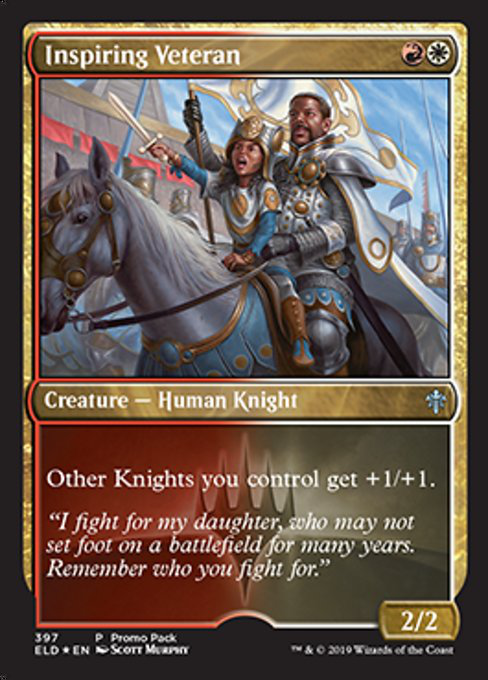

In [7]:
response = requests.get(images[0]['normal'])
img = Image.open(BytesIO(response.content))
img